In [1]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import sklearn

import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math
from python_speech_features import mfcc, logfbank





def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()





import sys
import numpy
import wave
import math
from scipy.signal import lfilter, hamming
# from scikits.talkbox import lpc
from librosa import lpc
"""
Estimate formants using LPC.
"""


def get_formants(x, Fs):

    # Get file as numpy array.
#     x = spf.readframes(-1)
    x = numpy.fromstring(x, 'int16')

    # Get Hamming window.
    N = len(x)
    w = numpy.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
#     x1 = lfilter([1., -0.63], 1, x1)
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
#     Fs = spf.getframerate()
    ncoeff = 2 + Fs / 1000
    print(ncoeff)
    A = lpc(x1, int(ncoeff))

#     A = lpc(x1, 8)

    # Get roots.
    rts = numpy.roots(A)
    rts = [r for r in rts if numpy.imag(r) >= 0]

    # Get angles.
    angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

    # Get frequencies.
#     Fs = spf.getframerate()
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs



def extract_features(segments, samplingFrequency):
    features_all = []
    for soundData in segments:
        if len(soundData) == 0:
            continue

        soundData = np.array(soundData, dtype="float")
    #     soundData = soundData.astype('float')
    #        --------Energy----------------
        energy = librosa.feature.rms(y=soundData)

            #------melspectogram----------
    #     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
    #                                                   n_mels=40,hop_length=hopLength)
            #-------MFCC------------------
    #     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
            #--------Spec Centroid---------
        spec_centr = librosa.feature.spectral_centroid(y=soundData)
            #--------Spec_bandwidth--------
        spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
            #--------Spec_contrast---------
        spec_contrast = librosa.feature.spectral_contrast(y = soundData)
            #------Spec Rolloff--------------
        spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.80)
            #------Tonal Centroid------------
        #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
            #------ZCR---------------------
        zcr = librosa.zero_crossings(y=soundData)
        zcr = (np.nonzero(zcr)[0].shape[0])
        print ("zcr", zcr)

        ##Other Features

        fourier_transform = np.fft.rfft(soundData)


        abs_fourier_transform = np.abs(fourier_transform)

        power_spectrum = np.square(abs_fourier_transform)

    #     print(fourier_transform)

        frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))

        ##Calculate the features for cough
        low_sp = 0
        high_sp = 0
        for i in range(frequency.shape[0]):

            if frequency[i]>0 and frequency[i]<=8000:
                low_sp += power_spectrum[i]
            elif frequency[i]>8000:
                high_sp += power_spectrum[i]

        mean_power = sum(power_spectrum)/len(power_spectrum) 
        power_below16 = low_sp
        power_above16 = high_sp
    #     print(power_spectrum)

        ##Speech features
        ##Calculate the ratio of (base + first harmonic energy) to total energy
        max_power = max(power_spectrum)
        print(max_power)
        print(np.argmax(power_spectrum))
        base_frequency = frequency[np.argmax(power_spectrum)]
        print (f"Maximum power is {max_power} at frequency {base_frequency}")
        first_harmonic_frequency = 2*base_frequency

        if first_harmonic_frequency not in frequency.tolist():
            first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))

        power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
        print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
        power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)

        ##VAD

        STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                         win_len=1, win_hop=1)


        ##Mask features
        ##energy ratio between 0–1 and 1–8 kHz (LH1000)
        low_sp = 0
        high_sp = 0
        for i in range(frequency.shape[0]):
            if frequency[i]>0 and frequency[i]<=1000:
                low_sp += power_spectrum[i]
            elif frequency[i]>1000 and frequency[i]<=25000:
                high_sp += power_spectrum[i]

        print ("Energy in 0 Hz - 1 kHz", low_sp)
        print ("Energy in 1 kHz - 8 kHz", high_sp)
        print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
        LH_ratio = low_sp/high_sp

        ## HNR
        HNR = signal.get_HNR( soundData, samplingFrequency )

        fb_feat = logfbank(soundData, samplingFrequency, nfilt=12)
    #     fb_feat = fb_feat.T
        avg_fb = np.average(fb_feat, axis=0)
        print(fb_feat.shape, fb_feat[0].shape, avg_fb.shape)
        fb1 = fb_feat[0]
        print("Filter bank: ", fb_feat.shape)
    #     plt.matshow(fb_feat)
        fb_beat_1 = fb_feat.flatten()
    ## index - feature
    #     0 - energy      
    #     1 - mel_spectrum (40, 12)
    #     2 - mfcc (13, 16)
    #     3 - spec_centr (1, 12)
    #     4 - spec_bandwidth (1, 12)
    #     5 - spec_contrast (7, 12)
    #     6 - spec_rolloff (1, 12)
    #     7 - zcr 
    #     8 - mean_power  
    #     9 - power_below16
    #     10 - power_above16
    #     11 - base_frequency
    #     12 - power_ratio
    #     13 - STenergy
    #     14 - LH_ratio
    #     15 - HNR
#         features_all = [energy, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy, LH_ratio, HNR]
    #     print("Shape of all features")
    #     for i in features_all:
    #         i = np.array(i)
    #         print(i.shape)

        features = [np.average(energy), np.average(spec_centr), np.average(spec_bandwidth),  np.average(spec_rolloff), zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, np.average(STenergy), LH_ratio, HNR] 

        print("Features",features, len(features))
        for i in fb1:
            features.append(i)


        formants = get_formants(soundData, samplingFrequency)
        formants = formants[1:6]
        print(formants)
        for i in formants:
            features.append(i)

        selected_features = []
    #     for index in indices:
    #         selected_features.append(features[index])

        non_privacy_features = abs_fourier_transform

        features_all.append(features)

    return np.array(features_all)



In [2]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import glob

# File paths
wav_files = glob.glob("ComParE2020_Mask/wav/*.wav")
label_file = 'Mask_labels_confidential.csv'

# Read the label file
labels_df = pd.read_csv(label_file)

# Function to segment audio files
def segment_audio(file_path, segment_length=0.5, overlap=0.1):
#     sr, y = wavfile.read(file_path)
    
    y, sr = librosa.load(file_path, sr=None)

    y, _ = librosa.effects.trim(y, top_db=20)

    segment_length_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments = []

    for start in range(0, len(y), segment_length_samples - overlap_samples):
        end = min(start + segment_length_samples, len(y))
        segments.append(y[start:end])

    return segments, sr

# Function to extract MFCC features
# def extract_features(segments, sr, lab, n_mfcc=20):
#     labels =[]
#     features = []
#     for segment in segments:
#         if len(segment) == 0:
#             continue
#         mfcc = librosa.feature.mfcc(segment, sr=sr, n_mfcc=n_mfcc)
#         mfcc_mean = np.mean(mfcc, axis=1)
#         features.append(mfcc_mean)
#         labels.append(lab)
#     return np.array(features), labels

# Process each audio file and extract features
all_features = []
all_labels = []



for file_path in wav_files:
    segments, sr = segment_audio(file_path)
    file_name = os.path.basename(file_path)

    # Retrieve labels for this file
    file_labels = labels_df[labels_df['file_name'] == file_name]['label'].values

    features  = extract_features(segments, sr)
    
    all_features.extend(features)
    labels = []
    for i in range(len(features)):
        labels.append(file_labels[0])
        
    print(labels)
    all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Checking the shapes of the features and labels
all_features.shape, all_labels.shape


zcr 1010
138232.63900776298
51
Maximum power is 138232.63900776298 at frequency 102.0
Power at first harmonic is 46669.257080617455 at frequency 204.0
Energy in 0 Hz - 1 kHz 849550.5316231108
Energy in 1 kHz - 8 kHz 17472.565576469562
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.62196841700265
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.15954259511605523, 1827.2843464003208, 2168.5970103592217, 2719.2398071289062, 1010, 216.7033156041816, 867023.0971995798, 0, 102.0, 0.2132589453609073, 0.00023469701409339905, 48.62196841700265, 8.561650644345068] 13
18.0


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_55721/1890800038.py:164: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_55721/1890800038.py:179: FutureWarning: Pass order=18 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


[1102.720734356897, 1907.8374854240362, 2809.70103580503, 3987.893600184697, 5206.770759659032]
zcr 278
73885.9614864807
50
Maximum power is 73885.9614864807 at frequency 100.0
Power at first harmonic is 21315.526784589092 at frequency 200.0
Energy in 0 Hz - 1 kHz 770593.425715365
Energy in 1 kHz - 8 kHz 3080.675556115444
energy ratio between 0–1 and 1–8 kHz (LH1000) 250.13780636057606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.14459975845879156, 766.735654466647, 1336.3817499464653, 823.64501953125, 278, 193.37315004807465, 773674.101271482, 0, 100.0, 0.12304926229927174, 0.0017454484477639198, 250.13780636057606, 13.977607565293138] 13
18.0
[1057.1596030504504, 1987.7623461521503, 2920.4438708957146, 3996.7761491009546, 5115.133962280637]
zcr 92
53161.82978836681
19
Maximum power is 53161.82978836681 at frequency 95.0
Power at first harmonic is 31863.133875387844 at frequency 190.0
Energy in 0 Hz - 1 kHz 124623.34179884267
Energy in 1 kHz - 8 kHz 1621.5940458171372
energ

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1664
  return f(*args, **kwargs)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w


zcr 517
98268.55777730313
131
Maximum power is 98268.55777730313 at frequency 262.0
Power at first harmonic is 8028.538412293364 at frequency 524.0
Energy in 0 Hz - 1 kHz 1151611.10467213
Energy in 1 kHz - 8 kHz 149502.9327597067
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.702933202809428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.1923481810611723, 1216.3906071187807, 1276.4375765640743, 1567.8863525390625, 517, 325.1992213132623, 1301114.0374318399, 0, 262.0, 0.08169648141245656, 0.09216620028018951, 7.702933202809428, 13.987536614662728] 13
18.0
[0.0, 1155.360247875045, 2110.7014584658928, 3005.831258590953, 4028.071983676311]
zcr 349
31582.059929341787
52
Maximum power is 31582.059929341787 at frequency 260.0
Power at first harmonic is 111.34501922905254 at frequency 520.0
Energy in 0 Hz - 1 kHz 167625.01832563308
Energy in 1 kHz - 8 kHz 8758.718603291893
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.13807554710487
(19, 12) (12,) (12,)
Filter bank:  (19, 12)
Feat

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.1644049292135048, 1748.1855743522183, 1830.3091136672513, 2736.7355346679688, 653, 257.47091134309625, 1030139.7255570043, 0, 284.0, 0.0431588295985479, 0.006363723427057266, 61.318020340644274, 16.920240515826613] 13
18.0
[1044.2083237891663, 1939.79609402639, 2877.3355361252898, 3999.2572066559737, 5103.281719141581]
zcr 222
46231.881681433726
54
Maximum power is 46231.881681433726 at frequency 270.0
Power at first harmonic is 9098.209260439251 at frequency 540.0
Energy in 0 Hz - 1 kHz 112856.53456691794
Energy in 1 kHz - 8 kHz 3508.942493515501
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.1625489091018
(19, 12) (12,) (12,)
Filter bank:  (19, 12)
Features [0.13372479970143608, 1517.6422368345277, 1632.1625313731408, 2114.8681640625, 222, 72.68707071494467, 116365.4770604338, 0, 270.0, 0.47545879455390444, 0.005947173573076725, 32.1625489091018, 20.566532664320654] 13
18.0
[1140.3313777320539, 1961.061124360412, 2703.43663704

zcr 806
44352.698004634905
218
Maximum power is 44352.698004634905 at frequency 436.0
Power at first harmonic is 0.8712786906099917 at frequency 872.0
Energy in 0 Hz - 1 kHz 799736.6711863994
Energy in 1 kHz - 8 kHz 8494.665179096159
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.14575552128969
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.1324124297531362, 2173.4560749874518, 2509.4595056144767, 4229.255676269531, 806, 202.0106835671058, 808231.3363654946, 0, 436.0, 0.05487640910793688, 0.008259419351816177, 94.14575552128969, 11.69716535906406] 13
18.0
[1017.9353997217693, 1991.810664076362, 2960.627224219346, 3992.630195065635, 5050.561465987691]
zcr 887
112277.3778602948
119
Maximum power is 112277.3778602948 at frequency 238.0
Power at first harmonic is 785.8114075808924 at frequency 476.0
Energy in 0 Hz - 1 kHz 1006625.8363494206
Energy in 1 kHz - 8 kHz 47174.43576874017
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.338375752581964
(49, 12) (12,) (12,)
Filter bank:

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/peakutils/peak.py:43: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


(19, 12) (12,) (12,)
Filter bank:  (19, 12)
Features [0.06978441806275831, 837.6043158622399, 1723.4115795537732, 635.2294921875, 62, 25.058067852106525, 40117.220006123214, 0, 190.0, 0.23986272372612802, 0.01843422744423151, 649.5713559727734, 15.305147505047524] 13
18.0
[1046.9707397957948, 1959.150553616962, 2909.295335347948, 4001.0548759882504, 5137.515792897126]
['clear', 'clear', 'clear']
zcr 448
224010.01595350757
97
Maximum power is 224010.01595350757 at frequency 194.0
Power at first harmonic is 3378.5899571979244 at frequency 388.0
Energy in 0 Hz - 1 kHz 1372108.648685426
Energy in 1 kHz - 8 kHz 25689.448310402488
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.411370773961494
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.19468202824937397, 1661.4188542242923, 1926.7145111766313, 2888.8137817382812, 448, 349.3634973112672, 1397798.096995833, 0, 194.0, 0.16267567642085487, 0.00011803209781646729, 53.411370773961494, 13.643808361870482] 13
18.0
[1014.685203594218, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.1818610731717025, 2182.4731261526563, 1923.1990808944706, 3173.455810546875, 1381, 323.59459820720093, 1294693.8716748764, 0, 108.0, 0.12835320054625549, 1.642853021621704e-06, 50.76699998176388, 9.626973207628199] 13
18.0
[1038.0298818454442, 1907.9755273267406, 2855.9889246054, 3984.7107127734976, 4966.2985982291875]
zcr 2720
62106.61948783417
52
Maximum power is 62106.61948783417 at frequency 104.0
Power at first harmonic is 4195.370388891299 at frequency 208.0
Energy in 0 Hz - 1 kHz 771341.1922585992
Energy in 1 kHz - 8 kHz 51782.357531071415
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.895829951267952
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.13782970637811948, 3963.172392162185, 2391.9927217743107, 5709.663391113281, 2720, 205.7345546271504, 823123.5497896677, 0, 104.0, 0.0805472598443939, 0.032529328018426895, 14.895829951267952, 6.87303971477076] 13
18.0
[1250.2269269254386, 1748.2451792984566, 2680.89213

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1024
  return f(*args, **kwargs)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1152
  return f(*args, **kwargs)


Energy in 0 Hz - 1 kHz 568581.2841675052
Energy in 1 kHz - 8 kHz 9484.454016322155
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.948762805851786
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.11423820443052334, 1304.6284418569062, 1910.6348702451296, 2097.4685668945312, 304, 144.48616016913087, 578065.7381838314, 0, 410.0, 0.10370531090991204, 1.0766088962554932e-06, 59.948762805851786, 13.761187287432632] 13
18.0
[1010.610879820978, 1970.7492423331255, 2940.190555394645, 3995.6791692164647, 5071.9009642762085]
zcr 86
18324.953957349207
37
Maximum power is 18324.953957349207 at frequency 185.0
Power at first harmonic is 223.5512147299338 at frequency 370.0
Energy in 0 Hz - 1 kHz 73473.7673591893
Energy in 1 kHz - 8 kHz 246.0111269004321
energy ratio between 0–1 and 1–8 kHz (LH1000) 298.6603422573089
(19, 12) (12,) (12,)
Filter bank:  (19, 12)
Features [0.09838530936852874, 998.4193444149984, 1690.580371331933, 1153.564453125, 86, 46.046717466758565, 73719.77848608975, 0, 18

zcr 1099
6578.212700241545
138
Maximum power is 6578.212700241545 at frequency 276.0
Power at first harmonic is 1540.8582161863458 at frequency 552.0
Energy in 0 Hz - 1 kHz 227835.9661813109
Energy in 1 kHz - 8 kHz 7242.382776328331
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.458702642173364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.05820452466568755, 2366.2459298223557, 2386.677520333358, 3955.3802490234375, 1099, 58.7551418002227, 235078.34895763922, 0, 276.0, 0.03453758006241047, 6.888061761856079e-06, 31.458702642173364, 7.015393833897648] 13
18.0
[1082.5137702121242, 1932.2169126459132, 2844.4815104608765, 4002.685769714324, 4937.361906222458]
zcr 207
6235.08065671085
35
Maximum power is 6235.08065671085 at frequency 208.33333333333334
Power at first harmonic is 495.3546097628191 at frequency 416.6666666666667
Energy in 0 Hz - 1 kHz 44747.410147039496
Energy in 1 kHz - 8 kHz 568.5898567621498
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.69892439139669
(16, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.12168687957019095, 962.9135777298394, 1370.60508171324, 1326.3107299804688, 302, 184.74968518112627, 739129.8408648362, 0, 120.0, 0.15825941735989482, 0.025057204999029636, 51.40020644295189, 15.347037794085725] 13
18.0
[1044.3268950919476, 1950.201207663278, 2880.220371328012, 3995.6841562190457, 5130.421303213415]
zcr 359
56379.719026926316
56
Maximum power is 56379.719026926316 at frequency 112.0
Power at first harmonic is 20947.80850417025 at frequency 224.0
Energy in 0 Hz - 1 kHz 403288.65716243105
Energy in 1 kHz - 8 kHz 28306.1788783505
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.247371886386246
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
Features [0.10328128395289755, 1207.0919250780685, 1506.0258226192962, 1978.363037109375, 359, 107.87199665779626, 431594.8360407819, 0, 112.0, 0.17916651882838075, 5.056057125329971e-05, 14.247371886386246, 13.885261345561903] 13
18.0
[1019.716874083613, 1962.0472021477779, 2921.9471

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=512
  return f(*args, **kwargs)


KeyboardInterrupt: 

In [5]:
# np.save('AeroSense_features.npy', all_features)
# np.save('AeroSense_labels.npy', all_labels)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)


In [7]:
len(all_features), len(all_labels), all_features[0].shape

(98124, 98124, (30,))

In [8]:
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)



In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)



Accuracy: 57.92%


In [10]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       clear       0.56      0.53      0.54      9370
        mask       0.59      0.63      0.61     10255

    accuracy                           0.58     19625
   macro avg       0.58      0.58      0.58     19625
weighted avg       0.58      0.58      0.58     19625



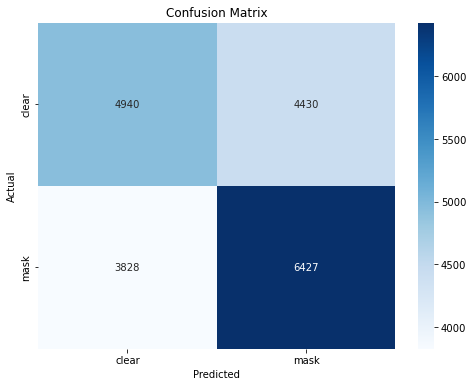

In [11]:
classes = np.unique(y_test)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

import matplotlib.pyplot as plt



precision: [0.56341241 0.59196832]
recall: [0.52721451 0.62671867]
fscore: [0.54471276 0.60884805]
support: [ 9370 10255]


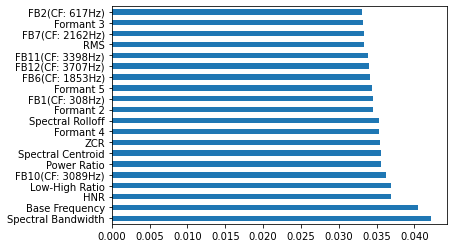

In [13]:
###RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
import pandas as pd



# # predict
# rfc_predict = clf.predict(X_test)# check performance
# # print('ROCAUC score:',metrics.roc_auc_score(y_test, rfc_predict))
# print('Accuracy score:',metrics.accuracy_score(y_test, rfc_predict))
# print('F1 score:',metrics.f1_score(y_test, rfc_predict))
# print("Recall:",metrics.recall_score(y_test, rfc_predict))
# print("Precision:",metrics.precision_score(y_test, rfc_predict))
# print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, rfc_predict))
# print(metrics.classification_report(y_test, rfc_predict))



# a = time.perf_counter()
# y_pred = rfc.predict(X_test)
# b = time.perf_counter()
# print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])



columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(int(val))+"Hz)")
    
for i in range(5):
    columns.append("Formant "+str(i+1))
    


feat_importances = pd.Series(clf.feature_importances_, index=columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()
